In [29]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import stan
import pandas as pd
from scipy import stats
from datetime import datetime
import time
import math
import scipy.stats

In [30]:
# They integrate to 1 
b0 = pd.read_csv('data/bottom_interpolated.csv', names=['gn1','density'],header=None )
l0 = pd.read_csv('data/light_interpolated.csv', names=['gn1','density'], header=None )
c0 = pd.read_csv('data/charm_interpolated.csv', names=['gn1','density'], header=None )

# parameters to sonstruct the data
pi = [0.2,0.3,0.5]  # proportion expected for each class
                    # slot0: probability of class0 x class0 x class0 x class0
                    # slot1: probability of class1 x class1 x class1 x class1
                    # slot2: probability of class0 x class0 x class1 x class1 (in any order)
theta_prior = [[1.5,2], [5,2.5]]
classes = [1,2]  # which curves to compare, 0=light, 1=charm, 2 = bottom

In [31]:
b0

,gn1,density
0,-7.000000,0.000000
1,-6.808081,0.000135
2,-6.616162,0.000270
3,-6.424242,0.000405
4,-6.232323,0.000540
...,...,...
95,11.232323,0.032507
96,11.424242,0.024380
97,11.616162,0.016254
98,11.808081,0.008127


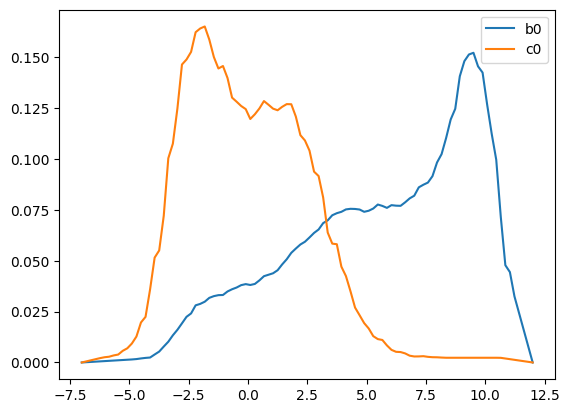

In [32]:
#plt.plot(l0['gn1'],l0['density'],label = 'l0')
plt.plot(b0['gn1'],b0['density'],label = 'b0')
plt.plot(c0['gn1'],c0['density'],label = 'c0')
plt.legend()
plt.show()

In [33]:
# reshape true curves to m bins
m = 25
vec = np.linspace(0,99,m)
myrows = [int(x) for x in vec]
ltrue = l0.iloc[myrows]
ctrue = c0.iloc[myrows]
btrue = b0.iloc[myrows]
ltrue.reset_index(drop=True, inplace=True)
ctrue.reset_index(drop=True, inplace=True)
btrue.reset_index(drop=True, inplace=True)
curves = [ltrue, ctrue, btrue]    
class0 = curves[classes[0]]
class1 = curves[classes[1]]
names = ['$j$','$c$','$b$']
name0 = names[classes[0]]
name1 = names[classes[1]]    
classname = [name0, name1]    

1.0175708943458595


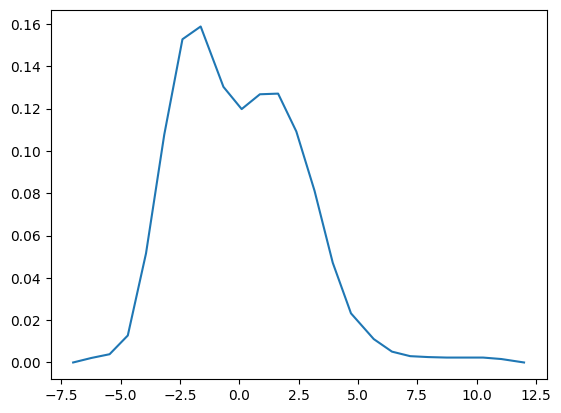

In [34]:
from scipy.integrate import simps
# Calcular el área bajo la curva usando la regla de Simpson
area = simps(ctrue['density'], ctrue['gn1'])
plt.plot(ctrue['gn1'],ctrue['density'])
print(area)
plt.show()

In [35]:
# determine start, stop and step of binning
start = min(class0['gn1'])
stop = max(class0['gn1'])
m = len(ltrue)  # just to be sure we didn't screw it in thinning the lists
step = (stop - start)/(m-1)
midbins = [start+(i+1/2)*step for i in range(0,m-1)]
edgebins = np.linspace(start,stop,m)
# These are the steps and bins for the betas that are in [0,1] and should be translated to the real start/stop span
start1 = 0
stop1 = 1
step1 = (stop1 - start1)/(m-1)
midbins1 = [start1+(i+1/2)*step1 for i in range(0,m-1)]

In [36]:
# Distributions
prior_distribution = [ [midbins, stats.beta.pdf(midbins1,theta_prior[0][0],theta_prior[0][1])], [midbins, stats.beta.pdf(midbins1,theta_prior[1][0],theta_prior[1][1])] ]
true_distribution = [ [midbins, [ (class0.iloc[i]['density']+class0.iloc[i+1]['density'])/2 for i in range(m-1)] ] , [midbins, [ (class1.iloc[i]['density']+class1.iloc[i+1]['density'])/2 for i in range(m-1)] ] ]

# Make probabilities sum 1
for i in range(len(true_distribution)):
    tmp = sum(true_distribution[i][1])+0.0*(m-1)
    true_distribution[i][1] = [(x+0.0)/tmp for x in true_distribution[i][1]]

for i in range(len(prior_distribution)):
    tmp = sum(prior_distribution[i][1])+0.0*(m-1)
    print(tmp)
    prior_distribution[i][1] = [(x+0.0)/tmp for x in prior_distribution[i][1]]
                                # We ad 0.001 to avoid a "-inf" in log_prior that doe snot enter into c++ STAN code

#print(prior_distribution[0][1])
      

24.052593231775628
24.008779867056607


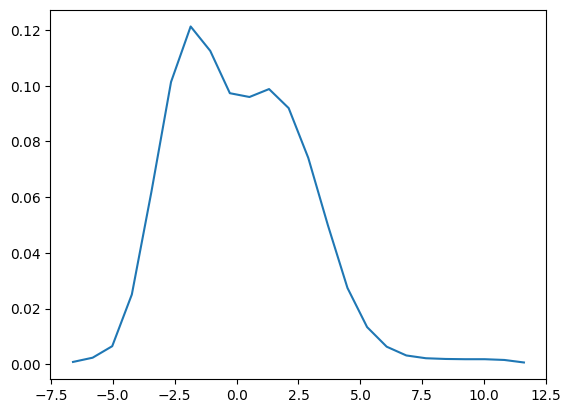

In [37]:
plt.plot(true_distribution[0][0],true_distribution[0][1])

In [18]:
#pi=[0,1,0]

In [38]:
####################################################
myseed=0
N=1000
np.random.seed(myseed)
features = 4
X = []  # 
sampledclass0 = []
sampledclass1 = []
for i in range(N): 
    # class0 0000
    # class1 1111
    # class2 0011 (any order)
    myclass = list( stats.multinomial.rvs(n=1, p=pi) ).index(1)
    if myclass == 2:  # if class is 0011, then I should choose at random in which order are the jets, but always being 2 X c0 and 2 x c1
        z = np.random.randint(6)
        c01, c02, c11, c12 = list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0] 
        sampled = [ [c01,c02,c11,c12], [c01,c11,c02,c12], [c01,c11,c12,c02], [c11,c01,c02,c12],  [c11,c01,c12,c02], [c11,c12,c01,c02] ]
        sampledclass0 = sampledclass0 + [c01, c02]
        sampledclass1 = sampledclass1 + [c11, c12]
        X.append([myclass]+sampled[z])
    else:
        tmp = list(np.random.choice(range(1,m), size = features, p = true_distribution[myclass][1]) ) 
        if myclass == 0: sampledclass0 = sampledclass0 + tmp
        if myclass == 1: sampledclass1 = sampledclass1 + tmp
        X.append([myclass]+ tmp)     
X=np.array(X)        
X0 = pd.DataFrame(X, columns=['class','xn0','xn1','xn2','xn3'])

In [20]:
X0

,class,xn0,xn1,xn2,xn3
0,1,19,18,16,20
1,1,23,16,21,18
2,1,8,9,6,22
3,1,23,21,17,21
4,1,11,23,18,16
...,...,...,...,...,...
995,0,9,7,8,6
996,2,12,17,11,10
997,2,6,12,19,14
998,2,7,19,5,10


In [21]:
#y = [(1/24)*stats.beta.pdf(x+(1/(2*(m-1))),5,2.5) for x in np.linspace(0,1-1/m,m-1)]   #cambiar true a prior arriba para plotear solo la beta

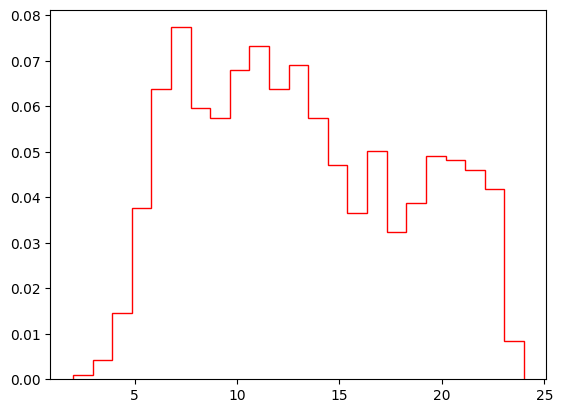

In [27]:
plt.hist(X0['xn0'], histtype='step',density=1, color='red',  bins=23)
#plt.hist(X0['xn1'], histtype='step',density=1, color='red',  bins=23)


#plt.plot(range(1,25),y)
plt.show()

In [24]:
X0['xn3']

0      20
1      18
2      22
3      21
4      16
       ..
995     6
996    10
997    14
998    10
999     6
Name: xn3, Length: 1000, dtype: int64